# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, height=8, width=8):
        self.height = height
        self.width = width
        self.grid = np.zeros((self.height, self.width)) - 1

        # Random start location for the agent
        self.current_location = (np.random.randint(0, height), np.random.randint(0, width))

        # Set locations for the bomb and the gold
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        """Moves the agent in the specified direction and returns the reward."""
        last_location = self.current_location

        # UP
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb)"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# Q-learning parameters
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor
epsilon = 0.1        # Exploration rate
episodes = 500       # Number of episodes

# Initialize Q-table
q_table = np.zeros((8, 8, len(GridWorld().actions)))

# Q-learning function
def q_learning():
    env = GridWorld()

    for episode in range(episodes):
        env.current_location = (4, np.random.randint(0, 5))  # Random start location
        state = env.current_location

        while True:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = random.choice(env.actions)  # Explore
            else:
                action = env.actions[np.argmax(q_table[state[0], state[1], :])]  # Exploit

            # Take action and observe reward
            reward = env.make_step(action)
            new_state = env.current_location
            action_index = env.actions.index(action)

            # Q-learning update rule
            q_table[state[0], state[1], action_index] = q_table[state[0], state[1], action_index] + alpha * (
                reward + gamma * np.max(q_table[new_state[0], new_state[1], :]) - q_table[state[0], state[1], action_index]
            )

            state = new_state

            # End episode if terminal state is reached
            if env.check_state() == 'TERMINAL':
                break

# Run Q-learning
q_learning()

# Display the learned policy
def display_policy():
    env = GridWorld()
    policy_grid = np.full((env.height, env.width), ' ')

    for i in range(env.height):
        for j in range(env.width):
            action_index = np.argmax(q_table[i, j, :])
            action = env.actions[action_index]

            if (i, j) == env.gold_location:
                policy_grid[i, j] = 'G'
            elif (i, j) == env.bomb_location:
                policy_grid[i, j] = 'B'
            elif action == 'UP':
                policy_grid[i, j] = '↑'
            elif action == 'DOWN':
                policy_grid[i, j] = '↓'
            elif action == 'LEFT':
                policy_grid[i, j] = '←'
            elif action == 'RIGHT':
                policy_grid[i, j] = '→'

    print("Learned Policy:")
    print(policy_grid)

# Display the final learned policy
display_policy()


Learned Policy:
[['→' '→' '→' 'G' '←' '←' '→' '↑']
 ['→' '→' '↑' 'B' '↑' '←' '←' '↓']
 ['→' '→' '↑' '→' '↑' '←' '→' '→']
 ['→' '→' '↑' '←' '↑' '←' '↑' '↑']
 ['→' '↑' '↑' '←' '↑' '←' '↓' '↓']
 ['↑' '↑' '↑' '←' '↑' '↑' '→' '↓']
 ['←' '↓' '→' '→' '→' '↑' '↓' '↓']
 ['←' '→' '↓' '↓' '←' '↓' '↓' '↓']]


In [4]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

# Testing the RandomAgent in the GridWorld environment
def test_random_agent():
    env = GridWorld()
    agent = RandomAgent()
    total_reward = 0
    state = env.current_location

    # Run the agent in the environment until a terminal state is reached
    while env.check_state() != 'TERMINAL':
        action = agent.choose_action(env.get_available_actions())
        reward = env.make_step(action)
        total_reward += reward
        print(f"Action: {action}, Reward: {reward}, Current Location: {env.current_location}")

    print("Total Reward:", total_reward)

# Run the test
test_random_agent()


Action: DOWN, Reward: -1.0, Current Location: (5, 2)
Action: LEFT, Reward: -1.0, Current Location: (5, 1)
Action: LEFT, Reward: -1.0, Current Location: (5, 0)
Action: DOWN, Reward: -1.0, Current Location: (6, 0)
Action: RIGHT, Reward: -1.0, Current Location: (6, 1)
Action: RIGHT, Reward: -1.0, Current Location: (6, 2)
Action: DOWN, Reward: -1.0, Current Location: (7, 2)
Action: RIGHT, Reward: -1.0, Current Location: (7, 3)
Action: UP, Reward: -1.0, Current Location: (6, 3)
Action: UP, Reward: -1.0, Current Location: (5, 3)
Action: UP, Reward: -1.0, Current Location: (4, 3)
Action: LEFT, Reward: -1.0, Current Location: (4, 2)
Action: UP, Reward: -1.0, Current Location: (3, 2)
Action: LEFT, Reward: -1.0, Current Location: (3, 1)
Action: UP, Reward: -1.0, Current Location: (2, 1)
Action: DOWN, Reward: -1.0, Current Location: (3, 1)
Action: LEFT, Reward: -1.0, Current Location: (3, 0)
Action: DOWN, Reward: -1.0, Current Location: (4, 0)
Action: RIGHT, Reward: -1.0, Current Location: (4, 1)

In [5]:
import numpy as np
import random

class Q_Agent():
    # Initialize
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()  # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height):  # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x, y)] = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}  # Initialize Q-values with zero

        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table or explores randomly with epsilon probability."""
        state = self.environment.current_location

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:  # Exploration
            action = np.random.choice(available_actions)
        else:  # Exploitation: Choose the action with the highest Q-value
            max_q_value = max(self.q_table[state].values())
            # Filter actions that have the maximum Q-value and choose randomly among them if tied
            best_actions = [a for a, q in self.q_table[state].items() if q == max_q_value]
            action = np.random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning."""
        # Current Q-value
        current_q = self.q_table[old_state][action]

        # Calculate the maximum future Q-value for the new state
        max_future_q = max(self.q_table[new_state].values())

        # Update Q-value using Q-learning formula
        self.q_table[old_state][action] = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)



In [6]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [7]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

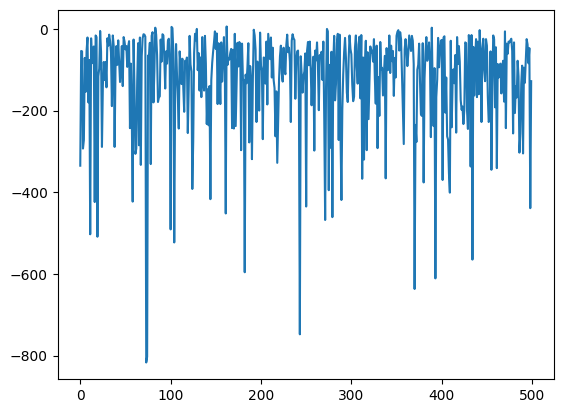

In [8]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

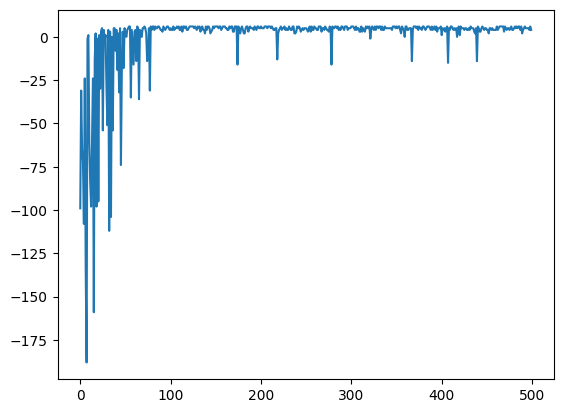

In [9]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [10]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.32571122840281197
	LEFT
		-0.30000000000000004
	RIGHT
		-0.224659
(0, 1)
	UP
		-0.1
	DOWN
		-0.11000000000000001
	LEFT
		-0.11000000000000001
	RIGHT
		2.4630133870725177
(0, 2)
	UP
		2.4389734351745016
	DOWN
		1.9062086558960551
	LEFT
		0.06733652010916881
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		-1.3877787807814457e-17
	DOWN
		1.2718157681724755
	LEFT
		9.99994531243513
	RIGHT
		0.03744160253342004
(0, 5)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		2.3806613847977403
	RIGHT
		-0.2
(0, 6)
	UP
		-0.4
	DOWN
		-0.42610000000000003
	LEFT
		-0.3147803646481
	RIGHT
		-0.40900000000000003
(0, 7)
	UP
		-0.4
	DOWN
		-0.506831
	LEFT
		-0.491
	RIGHT
		-0.4
(1, 0)
	UP
		-0.44661000000000006
	DOWN
		-0.4465593590000001
	LEFT
		-0.4
	RIGHT
		-0.36491391170453547
(1, 1)
	UP
		-0.2539
	DOWN
		-0.229
	LEFT
		-0.2
	RIGHT
		3.1539488342958633
(1, 2)
	UP
		8.999999999999986
	DOWN
		1.3148505798488532
	LEFT
		0.13760342780684787
